# Neurosymbolic Software Tutorial - Discrete - Solution

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/discrete_exercise_solutions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.


## Outline

- Part 1: Defining a DSL
- Part 2: Finding Programs
- Part 3: Abstraction Learning

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import neurosym as ns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("error")

from neurosym.examples.simple_dreamcoder.domain import *
from neurosym.examples.simple_dreamcoder.algorithm import *
from neurosym.examples.simple_dreamcoder.experiment import *



In [2]:
dsl = ns.examples.simple_dreamcoder.domain.example_dsl()

In [3]:
print(dsl.render())

              0 :: () -> f
              1 :: () -> f
              2 :: () -> f
              + :: (f, f) -> f
              - :: (f, f) -> f
              * :: (f, f) -> f
             ** :: (f, f) -> f
              / :: (f, f) -> f
            sin :: f -> f
           sqrt :: f -> f
              < :: (f, f) -> b
            ite :: (b, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>


In [4]:
xs, values = ns.examples.simple_dreamcoder.example_dataset(1000, 20, seed=1)
xs_test, values_test = ns.examples.simple_dreamcoder.example_dataset(1000, 20, seed=2)
plot_count = 3

def plot_some_sequences():
    for i in range(plot_count):
        plt.plot(xs_test, values_test[i], color=f"C{i}", alpha=0.25)
        plt.scatter(xs_test, values_test[i], color=f"C{i}", marker=".")

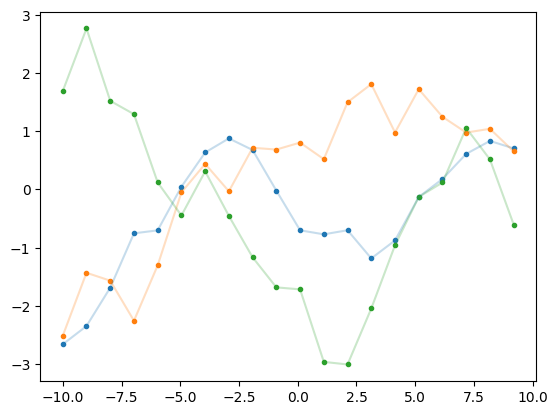

In [5]:
plot_some_sequences()

In [6]:
def plot_programs_against_data(dsl, best_programs):
    plot_some_sequences()
    best_programs = best_programs[:plot_count]
    _, evals = evaluate_all_programs(xs, dsl, best_programs)
    for prog, ev in zip(best_programs, evals):
        plt.plot(xs, ev, label=ns.render_s_expression(prog).replace("$", r"\$"))
    plt.legend()


We provide a function for finding the best program out of a list that matches a given data sequence:

Now we find the best programs among the first 50k enumerated programs

In [7]:
results = learning_curves_all("../outputs/simple_dreamcoder") 

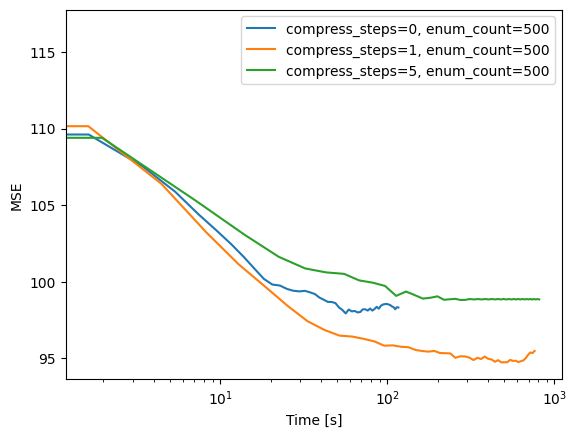

In [8]:
for i, (compression_steps_by_iteration, count) in enumerate(results):
    result = results[compression_steps_by_iteration, count]
    timings, val_errors = [np.array([r[k] for r in result]).mean(0) for k in ["timings", "val_errors"]]
    timings = timings - timings[0]
    plt.plot(timings, val_errors, label=f"compress_steps={compression_steps_by_iteration}, enum_count={count}", color=f"C{i}")
plt.xscale("log")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("MSE")
plt.show()